In [1]:
import networkx as nx
import numpy as np
import itertools as it
import random
import time
import scipy
from matplotlib import pyplot as plt
import fresnel
import os
import PIL

In [2]:
np.random.seed(100)
random.seed(100)

In [3]:
def coordination_pattern(x):
    """
    To do: obtain the neighbors of an input atom position
    Args:
        x: the position of atoms
    Returns:
        the neighbors of the atoms, excluding the center atoms
    """
    return np.array([x+np.array([0.5,0.5,0]),
                     x+np.array([-0.5,0.5,0]),
                     x+np.array([0.5,-0.5,0]),
                     x+np.array([-0.5,-0.5,0]),
                     x+np.array([0.5,0,0.5]),
                     x+np.array([0.5,0,-0.5]),
                     x+np.array([-0.5,0,0.5]),
                     x+np.array([-0.5,0,-0.5]),
                     x+np.array([0,0.5,0.5]),
                     x+np.array([0,-0.5,0.5]),
                     x+np.array([0,0.5,-0.5]),
                     x+np.array([0,-0.5,-0.5]),
                    ])
def neighbors(x):
    """
    To do: obtain the occupied sites for a given cell
    Args:
        x: the position of cells
    Returns:
        the occupied sites in the cells
    """
    #define sites of fcc cell where x is the body center
    return np.array([x+np.array([0.5,0,0]),
                     x+np.array([-0.5,0,0]),
                     x+np.array([0,-0.5,0]),
                     x+np.array([0,0.5,0]),
                     x+np.array([0,0,0.5]),
                     x+np.array([0,0,-0.5]),      
                     x+np.array([0.5,0.5,0.5]),
                     x+np.array([-0.5,-0.5,0.5]),
                     x+np.array([0.5,-0.5,0.5]),
                     x+np.array([-0.5,0.5,0.5]),           
                     x+np.array([0.5,0.5,-0.5]),
                     x+np.array([-0.5,-0.5,-0.5]),
                     x+np.array([0.5,-0.5,-0.5]),
                     x+np.array([-0.5,0.5,-0.5])   
                    ])
    

In [4]:
#define the kinetic constant for simulation
k_Au=-4.0
k_Ag=-4.4
Energy_ratio=0.7
Energy_ratio2=0.7
k_on_Au=0.100000
k_on_Ag=1.000000
random_seed = 42

path="/mnt/orkney/Chemobot/Nanobot-Monte_Carlo_Simulation/Au_Ag_7_traj/example_{}_{}_{}_{}_{}_{}_{}/".format(k_Au,k_Ag,Energy_ratio,Energy_ratio2,k_on_Au,k_on_Ag,random_seed)

In [5]:
# read in the initial structure
initial_atom_strucutre = np.loadtxt("/home/yibin/workspace/Growth_with_silverV3/atomList_TruncatedOctahedron.csv",delimiter=",")
initial_atom_strucutre = initial_atom_strucutre-np.array([0.5,0.5,0.5]) # slight movement

In [6]:
# get the trajecotry
count = 500000
site_temp_record_total = np.load(path+"structure/"+"site_temp_record_total%d.npy"%count,allow_pickle = True)
atom_type_record_total = np.load(path+"structure/"+"atom_type_record_total%d.npy"%count,allow_pickle = True)

In [7]:
# calculate the extra atom positions
# slight movement
extra_atom_sites = np.array([site_temp_record_total[i][0] for i in range(len(site_temp_record_total))]) - np.array([0.5,0.5,0.5])
event_indexes = np.array([site_temp_record_total[i][1] for i in range(len(site_temp_record_total))])
# the atomic sites that appeared in the trajecotry should be recorded
final_structure = np.unique(np.vstack((initial_atom_strucutre,extra_atom_sites)),axis=0)

In [8]:
# calculate the potential dipole site position for the given structure 
min_range = np.around(final_structure.min())
max_range = np.around(final_structure.max())
interval = 1.5
sites = min_range+np.arange(int((max_range-min_range)/interval)+3)*interval-interval

dipole_positions = []
for x in sites:
    for y in sites:
        for z in sites:
            dipole_positions.append([x,y,z])
dipole_positions = np.array(dipole_positions)

In [9]:
atom_lower = int(np.floor(dipole_positions.min()))
atom_upper = int(np.ceil(dipole_positions.max()))
ideal_atom_position = []
for x in range(atom_lower,atom_upper+int(3*np.ceil(interval))):
    for y in range(atom_lower,atom_upper+int(3*np.ceil(interval))):
        for z in range(atom_lower,atom_upper+int(3*np.ceil(interval))):
            ideal_atom_position.append([x,y,z])
ideal_atom_position = np.array(ideal_atom_position)
ideal_atom_position = np.unique(neighbors(ideal_atom_position).reshape(-1,3),axis=0).tolist()

In [10]:
# validate all the corresponding atoms were captured by the ideal case
final_structure = final_structure.tolist()
flag = 0
for i in final_structure:
    if not (i in ideal_atom_position):
        print('error!')

In [11]:
# the first output should be the subset of the second output
# the second output should be the subset of the third output
print(f'{np.array(final_structure).min()}_{np.array(final_structure).max()}')
print(f'{np.array(dipole_positions).min()}_{np.array(dipole_positions).max()}')
print(f'{np.array(ideal_atom_position).min()}_{np.array(ideal_atom_position).max()}')

-13.0_31.5
-14.5_33.5
-15.5_39.5


# Check fully occupied atom numbers

In [ ]:
# get the fully occupied dipole number for the ideal case
dipole_full_number = [] # calculate with the ideal atomic position
dipole_full_number2 = [] # directly calculated by the atoms between dipoles
# iterate through all the existing dipole positions
for dipole_position_temp in dipole_positions:
    lower = np.floor(dipole_position_temp)
    upper = np.ceil(dipole_position_temp+interval)
    position = []
    for x in range(int(lower[0]),int(upper[0])+1):
        for y in range(int(lower[1]),int(upper[1])+1):
            for z in range(int(lower[2]),int(upper[2])+1):
                position.append([x,y,z])
    position = np.unique(neighbors(position).reshape(-1,3),axis=0)
    in_dipole_interval = np.all((dipole_position_temp<=position)*(position<=dipole_position_temp+interval),axis=1)
    position = position[in_dipole_interval]
    dipole_full_number.append(sum([i.tolist() in ideal_atom_position for i in position]))
    dipole_full_number2.append(len(position))

In [ ]:
sum(abs(np.array(dipole_full_number)-32))
# this indicates the cell contains 32 dipoles to fill it up

# Get the dipoles that get involved in the whole transformation process

In [12]:
# get the fully occupied dipole number for the ideal case
dipole_current_coord = []
# iterate through all the existing dipole positions
for dipole_position_temp in dipole_positions:
    lower = np.floor(dipole_position_temp)
    upper = np.ceil(dipole_position_temp+interval)
    position = []
    for x in range(int(lower[0]),int(upper[0])+1):
        for y in range(int(lower[1]),int(upper[1])+1):
            for z in range(int(lower[2]),int(upper[2])+1):
                position.append([x,y,z])
    position = np.unique(neighbors(position).reshape(-1,3),axis=0)
    in_dipole_interval = np.all((dipole_position_temp<=position)*(position<=dipole_position_temp+interval),axis=1)
    position = position[in_dipole_interval]
    dipole_current_coord.append(sum([i.tolist() in final_structure for i in position]))

In [13]:
dipole_positions = dipole_positions[np.array(dipole_current_coord)==32]

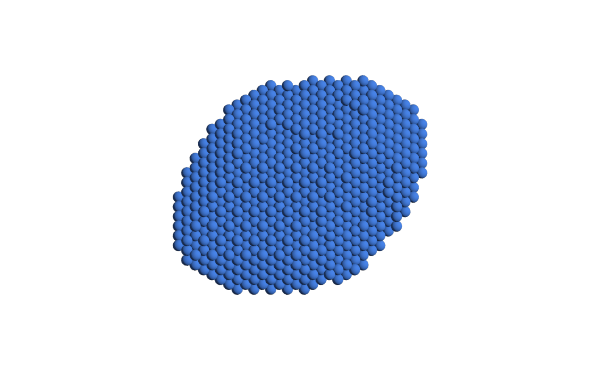

In [14]:
scene = fresnel.Scene()
geometry1 = fresnel.geometry.Sphere(scene, N=len(dipole_positions), radius=np.sqrt(2)/2)
geometry1.material = fresnel.material.Material(color=fresnel.color.linear([0.25,0.5,0.9]),
                                              roughness=0.8)

geometry1.position[:] = dipole_positions
scene.camera = fresnel.camera.Orthographic.fit(scene)
fresnel.preview(scene)

In [15]:
print(len(dipole_positions))

3195


# Initialize the atom coordinates

In [16]:
initial_atom_strucutre = initial_atom_strucutre.tolist()
# get the fully occupied dipole number for the ideal case
dipole_current_coord = []
# iterate through all the existing dipole positions
for dipole_position_temp in dipole_positions:
    lower = np.floor(dipole_position_temp)
    upper = np.ceil(dipole_position_temp+interval)
    position = []
    for x in range(int(lower[0]),int(upper[0])+1):
        for y in range(int(lower[1]),int(upper[1])+1):
            for z in range(int(lower[2]),int(upper[2])+1):
                position.append([x,y,z])
    position = np.unique(neighbors(position).reshape(-1,3),axis=0)
    in_dipole_interval = np.all((dipole_position_temp<=position)*(position<=dipole_position_temp+interval),axis=1)
    position = position[in_dipole_interval]
    dipole_current_coord.append(sum([i.tolist() in initial_atom_strucutre for i in position]))

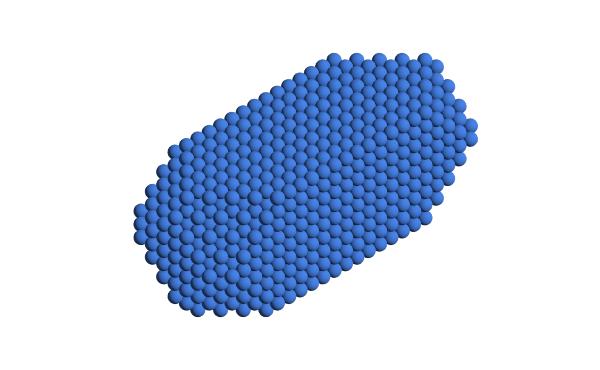

In [17]:
scene = fresnel.Scene()
geometry1 = fresnel.geometry.Sphere(scene, N=len(dipole_positions[np.array(dipole_current_coord)==32]), radius=np.sqrt(2)/2)
geometry1.material = fresnel.material.Material(color=fresnel.color.linear([0.25,0.5,0.9]),
                                              roughness=0.8)

geometry1.position[:] = dipole_positions[np.array(dipole_current_coord)==32]
scene.camera = fresnel.camera.Orthographic.fit(scene)
fresnel.preview(scene)

In [18]:
print(len(dipole_positions))

3195


In [19]:
np.savetxt(f'./dipole_positions_{random_seed}.csv',dipole_positions,delimiter=',')
np.savetxt(f'./dipole_current_coord_{random_seed}.csv',dipole_current_coord,delimiter=',')

# Loop through the event

In [20]:
# read in the generated dipole position
dipole_positions = np.loadtxt(f'./dipole_positions_{random_seed}.csv',delimiter=',')
# read in the calculated atom number inside the dipoles
dipole_current_coord = np.loadtxt(f'./dipole_current_coord_{random_seed}.csv',delimiter=',')
# get the trajecotry information
count = 500000
site_temp_record_total = np.load(path+"structure/"+"site_temp_record_total%d.npy"%count,allow_pickle = True)
atom_type_record_total = np.load(path+"structure/"+"atom_type_record_total%d.npy"%count,allow_pickle = True)
# calculate the extra atom positions
# slight movement
extra_atom_sites = np.array([site_temp_record_total[i][0] for i in range(len(site_temp_record_total))]) - np.array([0.5,0.5,0.5])
event_indexes = np.array([site_temp_record_total[i][1] for i in range(len(site_temp_record_total))])

In [21]:
# get the number of Au/Ag atoms in the dipole
coord_infor = {}
count = 0
for dipole_position_temp in dipole_positions:
    coord_infor[tuple(dipole_position_temp)] = {}
    coord_infor[tuple(dipole_position_temp)]['coord'] = [dipole_current_coord[count],0]
    if sum(coord_infor[tuple(dipole_position_temp)]['coord']) == 32:
        coord_infor[tuple(dipole_position_temp)]['type'] = 'dipole'
    else:
        coord_infor[tuple(dipole_position_temp)]['type'] = 'vacant'
    count = count + 1
dipole_positions = dipole_positions.tolist()

In [22]:
np.random.seed(random_seed)
events = []
# get the change of the nanostructures through the atomic changes
for i in range(len(extra_atom_sites)):
    extra_atom_site_tmp = extra_atom_sites[i]
    # get the sites that is involved by this atomic site
    dipole_site = []
    site_x = sites[(sites>=(extra_atom_site_tmp[0] - interval))*(sites<=(extra_atom_site_tmp[0]))]
    site_y = sites[(sites>=(extra_atom_site_tmp[1] - interval))*(sites<=(extra_atom_site_tmp[1]))]
    site_z = sites[(sites>=(extra_atom_site_tmp[2] - interval))*(sites<=(extra_atom_site_tmp[2]))]
    for x in site_x:
        for y in site_y:
            for z in site_z:
                dipole_site.append([x,y,z])
    np.random.shuffle(dipole_site)
                
    if event_indexes[i] == 0:
        # addition event
        for dipole_site_temp in dipole_site:
            if dipole_site_temp in dipole_positions:
                if atom_type_record_total[i] == 'Au':
                    coord_infor[tuple(dipole_site_temp)]['coord'][0] = coord_infor[tuple(dipole_site_temp)]['coord'][0] + 1
                else:
                    coord_infor[tuple(dipole_site_temp)]['coord'][1] = coord_infor[tuple(dipole_site_temp)]['coord'][1] + 1
                # judge if a new dipole should be added after the addition event
                if coord_infor[tuple(dipole_site_temp)]['coord'][0] + coord_infor[tuple(dipole_site_temp)]['coord'][1] ==32:
                    events.append([dipole_site_temp,
                                   coord_infor[tuple(dipole_site_temp)]['coord'].copy(),
                                   'add',
                                   atom_type_record_total[i]])
                    print(i)
                    coord_infor[tuple(dipole_site_temp)]['type']='dipole'
                            
    # replacement
    elif event_indexes[i] == 1:
        for dipole_site_temp in dipole_site:
            if dipole_site_temp in dipole_positions:
                if atom_type_record_total[i] == 'Au':
                    # judge the event type and atom type
                    coord_infor[tuple(dipole_site_temp)]['coord'][0] = coord_infor[tuple(dipole_site_temp)]['coord'][0] - 1
                    coord_infor[tuple(dipole_site_temp)]['coord'][1] = coord_infor[tuple(dipole_site_temp)]['coord'][1] + 1
                else:
                    # judge the event type and atom type
                    coord_infor[tuple(dipole_site_temp)]['coord'][0] = coord_infor[tuple(dipole_site_temp)]['coord'][0] + 1
                    coord_infor[tuple(dipole_site_temp)]['coord'][1] = coord_infor[tuple(dipole_site_temp)]['coord'][1] - 1
                    
                if coord_infor[tuple(dipole_site_temp)]['coord'][0] + coord_infor[tuple(dipole_site_temp)]['coord'][1] ==32:
                    # Replace the Au dipole with Ag dipole
                    events.append([dipole_site_temp,
                                   coord_infor[tuple(dipole_site_temp)]['coord'].copy(),
                                   'replace',
                                   atom_type_record_total[i]])
                    print(i)
    else:
        # deletion event
        for dipole_site_temp in dipole_site:
            if dipole_site_temp in dipole_positions:
                # judge the event type and atom type
                if atom_type_record_total[i] == 'Au':
                    coord_infor[tuple(dipole_site_temp)]['coord'][0] = coord_infor[tuple(dipole_site_temp)]['coord'][0] - 1
                else:
                    coord_infor[tuple(dipole_site_temp)]['coord'][1] = coord_infor[tuple(dipole_site_temp)]['coord'][1] - 1
                if coord_infor[tuple(dipole_site_temp)]['type'] != 'vacant':
                    events.append([dipole_site_temp,
                                   coord_infor[tuple(dipole_site_temp)]['coord'].copy(),
                                   'delete',
                                   atom_type_record_total[i]])
                    coord_infor[tuple(dipole_site_temp)]['type'] = 'vacant'
                    print(i)

425
1069
1728
1835
1835
2056
2073
2207
2308
2383
2456
2461
2514
2659
2783
2919
2993
3061
3145
3288
3334
3371
3431
3431
3463
3474
3500
3526
3535
3573
3591
3604
3608
3608
3657
3665
3677
3893
3896
3903
3915
3937
3942
3946
3952
3987
4014
4096
4128
4128
4140
4142
4165
4171
4238
4238
4247
4265
4273
4282
4282
4289
4290
4305
4357
4360
4362
4363
4377
4379
4381
4385
4415
4425
4426
4436
4458
4474
4476
4495
4495
4495
4496
4522
4530
4552
4562
4613
4614
4614
4616
4630
4637
4650
4660
4662
4671
4693
4714
4714
4717
4724
4725
4730
4730
4767
4776
4790
4800
4809
4818
4832
4834
4834
4834
4839
4885
4892
4892
4908
4912
4916
4949
4968
4968
4970
4988
5003
5014
5018
5032
5038
5038
5038
5038
5066
5069
5072
5074
5076
5085
5096
5112
5122
5135
5144
5151
5158
5158
5161
5161
5165
5165
5168
5168
5178
5187
5194
5218
5225
5280
5291
5322
5322
5323
5327
5327
5334
5342
5348
5366
5385
5387
5397
5418
5423
5423
5426
5430
5437
5437
5453
5455
5461
5464
5466
5481
5487
5498
5503
5504
5506
5506
5550
5562
5564
5564
5573
5573
5580
5

19539
19540
19540
19543
19545
19547
19552
19556
19566
19580
19580
19610
19610
19628
19628
19635
19657
19658
19658
19660
19666
19666
19668
19703
19703
19731
19766
19766
19766
19766
19771
19771
19777
19777
19777
19777
19784
19805
19819
19820
19855
19863
19884
19884
19902
19955
19969
19970
19992
19992
19992
19992
20012
20012
20012
20012
20046
20051
20055
20065
20074
20074
20074
20097
20097
20113
20114
20115
20115
20117
20117
20132
20154
20163
20163
20205
20207
20216
20216
20228
20253
20253
20270
20289
20292
20292
20302
20304
20322
20347
20391
20391
20392
20399
20417
20421
20453
20458
20512
20515
20515
20522
20560
20561
20561
20567
20572
20573
20577
20595
20597
20600
20618
20618
20618
20618
20620
20645
20677
20685
20699
20702
20702
20719
20719
20725
20731
20736
20740
20786
20786
20786
20810
20810
20810
20810
20865
20881
20889
20889
20899
20915
20917
20943
20949
21009
21133
21136
21136
21197
21197
21197
21211
21211
21220
21270
21270
21282
21282
21293
21367
21369
21430
21443
21486
21486
2148

In [23]:
np.save(f'./event_{random_seed}.npy',events)

/home/yibin/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [24]:
import pickle
with open(f'./coord_infor_{random_seed}.pickle', 'wb') as handle:
    pickle.dump(coord_infor, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [25]:
events

[[[-8.5, -7.0, 0.5], [31.0, 1], 'add', 'Ag'],
 [[-8.5, -7.0, 0.5], [32.0, 0], 'replace', 'Ag'],
 [[-8.5, -7.0, 11.0], [30.0, 2], 'add', 'Ag'],
 [[-8.5, -7.0, 8.0], [30.0, 2], 'add', 'Ag'],
 [[-8.5, -7.0, 6.5], [30.0, 2], 'add', 'Ag'],
 [[-7.0, -8.5, 9.5], [31.0, 1], 'add', 'Ag'],
 [[-7.0, -8.5, 9.5], [32.0, 0], 'replace', 'Ag'],
 [[-8.5, -7.0, 11.0], [31.0, 1], 'replace', 'Ag'],
 [[6.5, 0.5, 14.0], [25.0, 7], 'add', 'Ag'],
 [[-8.5, -7.0, 9.5], [31.0, 1], 'add', 'Ag'],
 [[6.5, -1.0, -1.0], [25.0, 7], 'add', 'Ag'],
 [[6.5, -1.0, -1.0], [26.0, 6], 'replace', 'Ag'],
 [[-8.5, -7.0, 8.0], [31.0, 1], 'replace', 'Ag'],
 [[6.5, -5.5, 11.0], [28.0, 4], 'add', 'Ag'],
 [[-8.5, -7.0, 14.0], [31.0, 1], 'add', 'Ag'],
 [[6.5, -1.0, -1.0], [27.0, 5], 'replace', 'Ag'],
 [[6.5, 0.5, 14.0], [26.0, 6], 'replace', 'Ag'],
 [[6.5, 0.5, 14.0], [27.0, 5], 'replace', 'Ag'],
 [[-8.5, -7.0, 15.5], [31.0, 1], 'add', 'Ag'],
 [[-8.5, -7.0, 12.5], [30.0, 2], 'add', 'Ag'],
 [[6.5, -5.5, 11.0], [29.0, 3], 'replace', 'Ag

In [26]:
len(events)

2196